In [69]:
def ses(previous,data,a,ini):
    
    S=np.zeros(len(previous))
    S[0]= ini
    # print('S0: {}'.format(S[0]))
    for i in range(1,len(previous)):
        S[i]= a*previous[i]+(1-a)*S[i-1]
        # print('S{}: {:.4f}'.format(i,S[i]))
    return S
    
def des(previous,target,rate,a_0,b_0,s_0,s2_0):
    S=np.zeros(len(previous))
    S2=np.zeros(len(previous))
    a=np.zeros(len(previous))
    b=np.zeros(len(previous))
    xhat = np.zeros(len(previous))
    
    S[0]= s_0
    S2[0] = s2_0
    a[0] = a_0
    b[0] = b_0
    xhat[0] = a[0] + b[0]
    
    # print('S0:',S[0])
    # print('S2_0:',S2[0])
    # print('a_0:',2*S[0]-S2[0])
    # print('b_0:',(S[0]-S2[0])*(rate/(1-rate)))
    # print('x_hat0:',2*S[0]-S2[0] + (S[0]-S2[0])*(rate/(1-rate)))
    # print('real_data_1:{:.4f}'.format(target[0]))
    # print()
    
    for i in range(1,len(previous)):
        S[i]= rate*previous[i]+(1-rate)*S[i-1]
        S2[i]= rate*S[i]+(1-rate)*S2[i-1]
        a[i] = 2*S[i] - S2[i]
        b[i] = (S[i]-S2[i])*(rate/(1-rate))
        xhat[i-1] = a[i] + b[i]
        
        # print('a_{}:{:.4f}'.format(i,a[i]))
        # print('b_{}:{:.4f}'.format(i,b[i]))
        # print('x_hat{}:{:.4f}'.format(i,xhat[i-1]))
        # print('real_data_{}:{:.4f}'.format(i+1,target[i]))
        # print()
    return xhat

def holt_linear(previous,target,a0,b0,alpha,beta):
    a=np.zeros(len(previous))
    b=np.zeros(len(previous))
    yhat = np.zeros(len(previous))
    
    a[0] = a0
    b[0] = b0
    yhat[0] = a0+b0
    
    # print('a_0:',a0)
    # print('b_0:',b0)
    # print('X_hat1:',a0+b0)
    # print('real_data_0:',target[0])
    # print()
    
    for i in range(1,len(previous)):
        a[i]= alpha*previous[i]+(1-alpha)*(a[i-1]+b[i-1])
        b[i]= beta*(a[i]-a[i-1])+(1-beta)*b[i-1]
        yhat[i-1] = a[i] + b[i]
        
        # print('a_{}:{:.4f}'.format(i,a[i]))
        # print('b_{}:{:.4f}'.format(i,b[i]))
        # print('X_hat{}(predict):{:.4f}'.format(i+1,yhat[i-1]))
        # print('real_data_{}:{:.4f}'.format(i+1,target[i]))
        # print()
    return yhat
    
def holt_multi(previous,target,a0,b0,alpha,beta):
    a=np.zeros(len(previous))
    b=np.zeros(len(previous))
    yhat = np.zeros(len(previous))
    
    a[0] = a0
    b[0] = b0
    yhat[0] = a0*b0
    
    # print('a_0',a0)
    # print('b_0',b0)
    # print('yhat_0:',a0*b0)
    # print('real_data_0:',target[0])
    # print()
    
    for i in range(1,len(previous)):
        a[i]= alpha*previous[i]+(1-alpha)*(a[i-1]*b[i-1])
        b[i]= beta*(a[i]/a[i-1])+(1-beta)*b[i-1]
        yhat[i-1] = a[i]*b[i]
        
        # print('a_{}:{:.4f}'.format(i,a[i]))
        # print('b_{}:{:.4f}'.format(i,b[i]))
        # print('y_hat{}(predict):{:.4f}'.format(i,yhat[i-1]))
        # print('real_data_{}:{:.4f}'.format(i+1,target[i]))
        # print()
    
    return yhat


### time series model prediction demonstration using tesla 2021 stock close price

Text(0.5, 1.0, 'Tesla stock price in 2021')

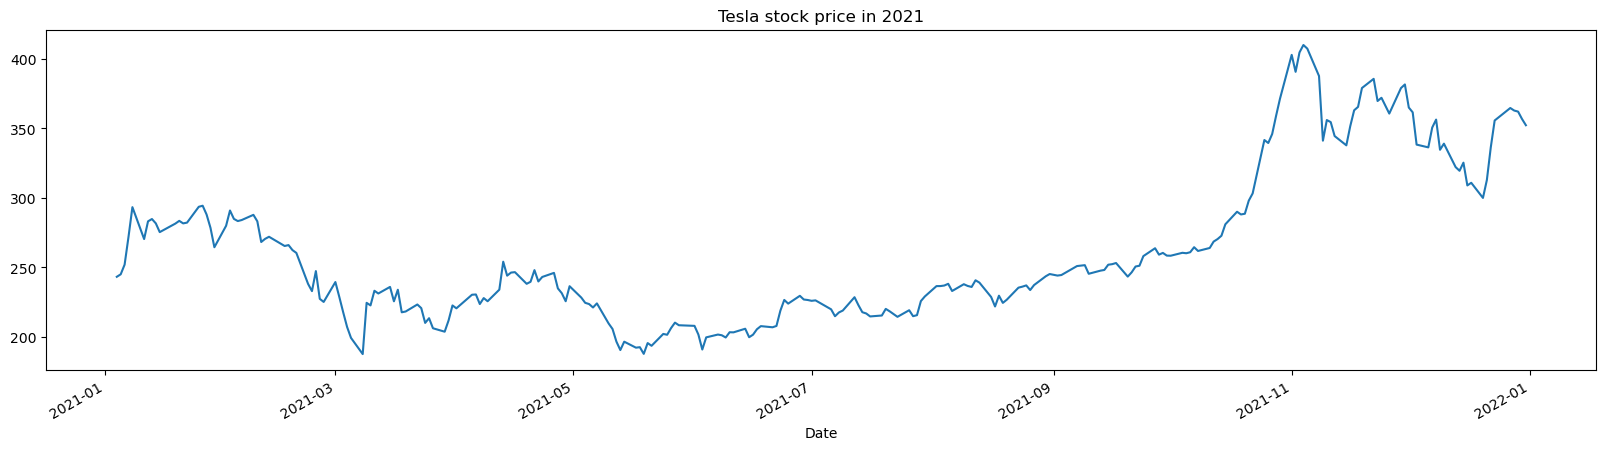

In [70]:
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import datetime as dt
import numpy as np
import pandas as pd

start = dt.date(2021,1,2)
end = dt.date(2021,12,31)
tesla = web.get_data_yahoo("TSLA",start,end)

plt.figure(figsize=(20,5))
graph = tesla['Close'].plot()
graph.set_title('Tesla stock price in 2021')

### Simple exponential smoothing

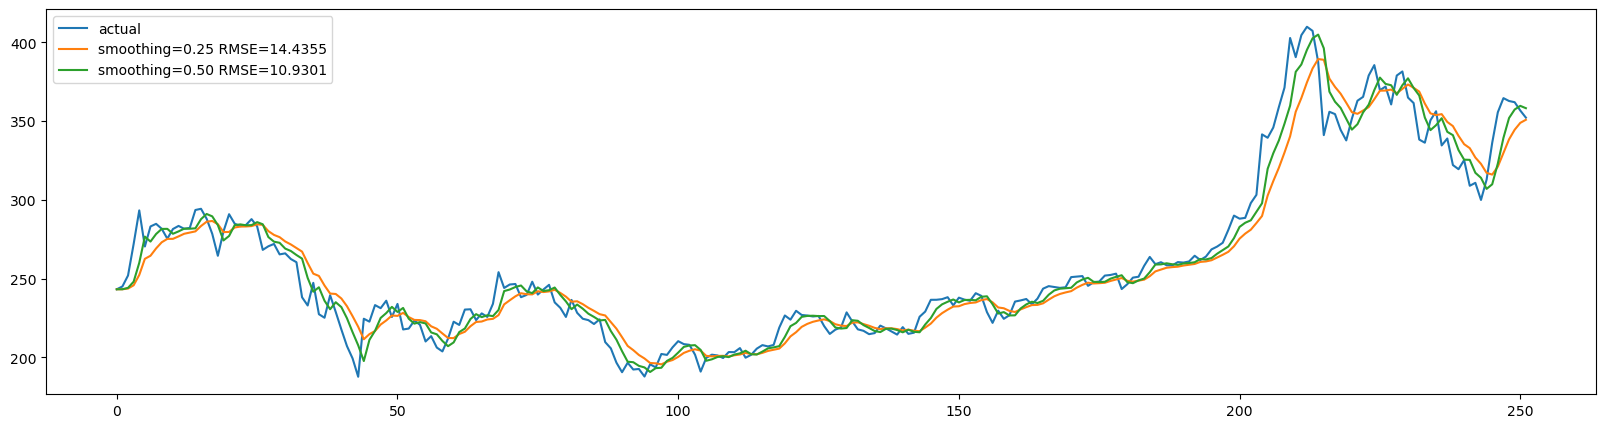

In [71]:
from sklearn.metrics import mean_squared_error
from math import sqrt


previous = list(tesla['Close'][0:len(tesla['Close'])-1])
previous.insert(0,0)
target = list(tesla['Close'])

# get optimal smoothing rate by getting smallest RMSE
smallest_rms = 1000
for i in np.arange(0,1,0.01):
    y_predicted = ses(previous,target,i,target[0])
    rms = sqrt(mean_squared_error(target, y_predicted))
    if (rms< smallest_rms):
        smallest_rms = rms

y_predicted_sm025 = ses(previous,target,0.25,target[0])
y_predicted_sm050 = ses(previous,target,0.5,target[0])
rmse_sm025 = sqrt(mean_squared_error(target, y_predicted_sm025))
rmse_sm050 = sqrt(mean_squared_error(target, y_predicted_sm050))
plt.figure(figsize=(20,5))
plt.plot(np.array(tesla['Close']))
plt.plot(y_predicted_sm025)
plt.plot(y_predicted_sm050)

plt.legend(["actual",f"smoothing=0.25 RMSE={rmse_sm025:.4f}",f"smoothing=0.50 RMSE={rmse_sm050:.4f}"])

### Double exponential smoothing

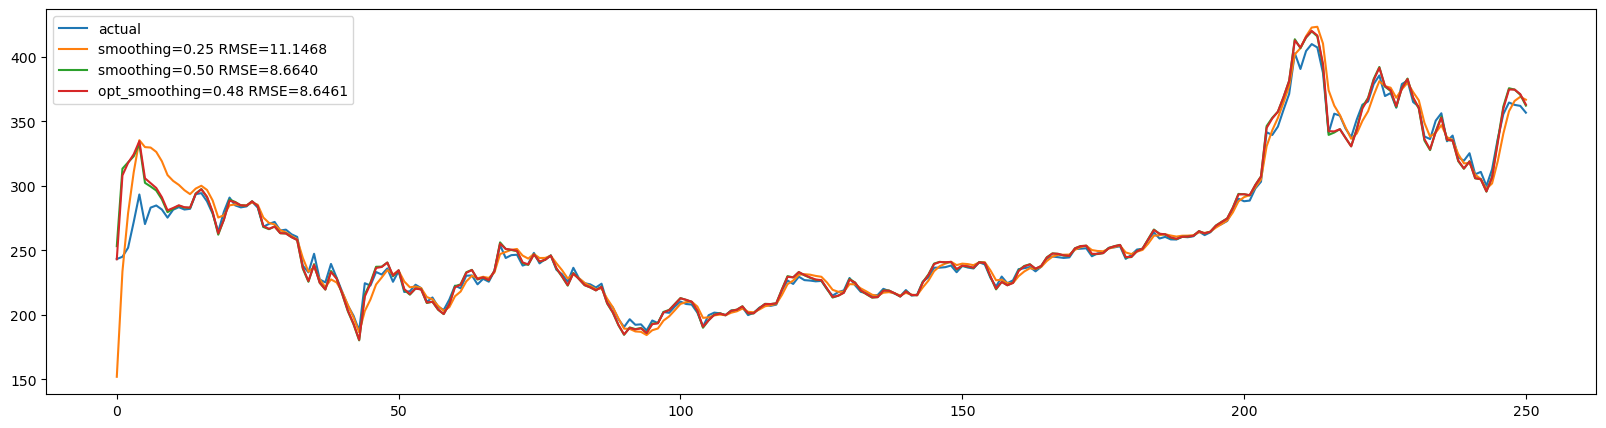

In [72]:
previous = list(tesla['Close'][0:len(tesla['Close'])-1])
previous.insert(0,0)
target = list(tesla['Close'])

rate = 0.1
a_0 = 200
b_0 = 20
s_0 =  -10
s2_0 = -20


# get optimal smoothing rate by getting smallest RMSE
smallest_rms = 1000

for i in np.arange(0,1,0.01):
    y_predicted = des(previous,target,i,a_0,b_0,s_0,s2_0)
    rms = sqrt(mean_squared_error(target, y_predicted))
    if (rms< smallest_rms):
        smallest_rms = rms
        opt_rate = i

target = target[:251]
y_predicted_sm025 = des(previous,target,0.3,a_0,b_0,s_0,s2_0)[:251]
y_predicted_sm050 = des(previous,target,0.50,a_0,b_0,s_0,s2_0)[:251]
y_predicted_opt = des(previous,target,opt_rate,a_0,b_0,s_0,s2_0)[:251]

rmse_sm025 = sqrt(mean_squared_error(target, y_predicted_sm025))
rmse_sm050 = sqrt(mean_squared_error(target, y_predicted_sm050))
rmse_opt = sqrt(mean_squared_error(target, y_predicted_opt))

plt.figure(figsize=(20,5))
plt.plot(np.array(tesla['Close'][:251]))
plt.plot(y_predicted_sm025)
plt.plot(y_predicted_sm050)
plt.plot(y_predicted_opt)

plt.legend(["actual",
            f"smoothing=0.25 RMSE={rmse_sm025:.4f}",
            f"smoothing=0.50 RMSE={rmse_sm050:.4f}",
            f"opt_smoothing={opt_rate} RMSE={rmse_opt:.4f}"])

### Holt's linear trend

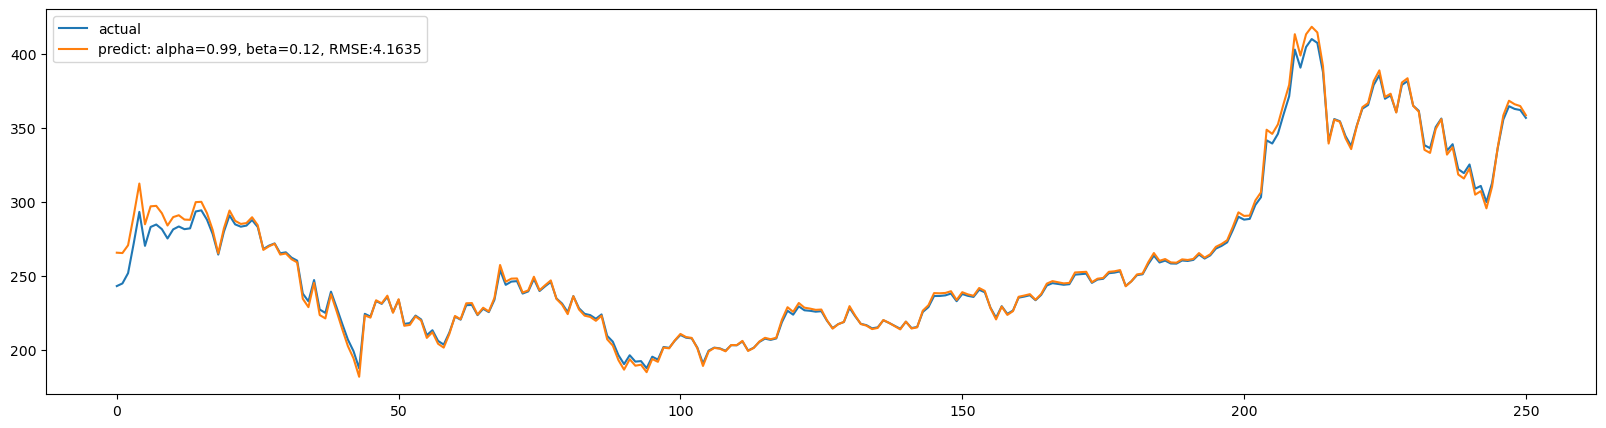

In [73]:
previous = list(tesla['Close'][0:len(tesla['Close'])-1])
previous.insert(0,0)
target = list(tesla['Close'])

a0 = 200
b0 = 20
alpha = np.arange(0,1,0.01)
beta = np.arange(0,1,0.01)

smallest_rms = 1000
for i in alpha:
    for j in beta:
        y_predicted = holt_linear(previous,target,a0,b0,i,j)
        rms = sqrt(mean_squared_error(target, y_predicted)) 
        if (rms < smallest_rms):
            smallest_rms = rms
            opt_alpha = i
            opt_beta = j

y_real = np.array(tesla['Close'])[:251]
y_pred = holt_linear(previous,target,a0,b0,opt_alpha,opt_beta)[:251]
rms = sqrt(mean_squared_error(y_real, y_pred)) 

plt.figure(figsize=(20,5))
plt.plot(y_real)
plt.plot(y_pred)
plt.legend(["actual",f"predict: alpha={opt_alpha}, beta={opt_beta}, RMSE:{rms:.4f}"])

### holt winters multiplicative

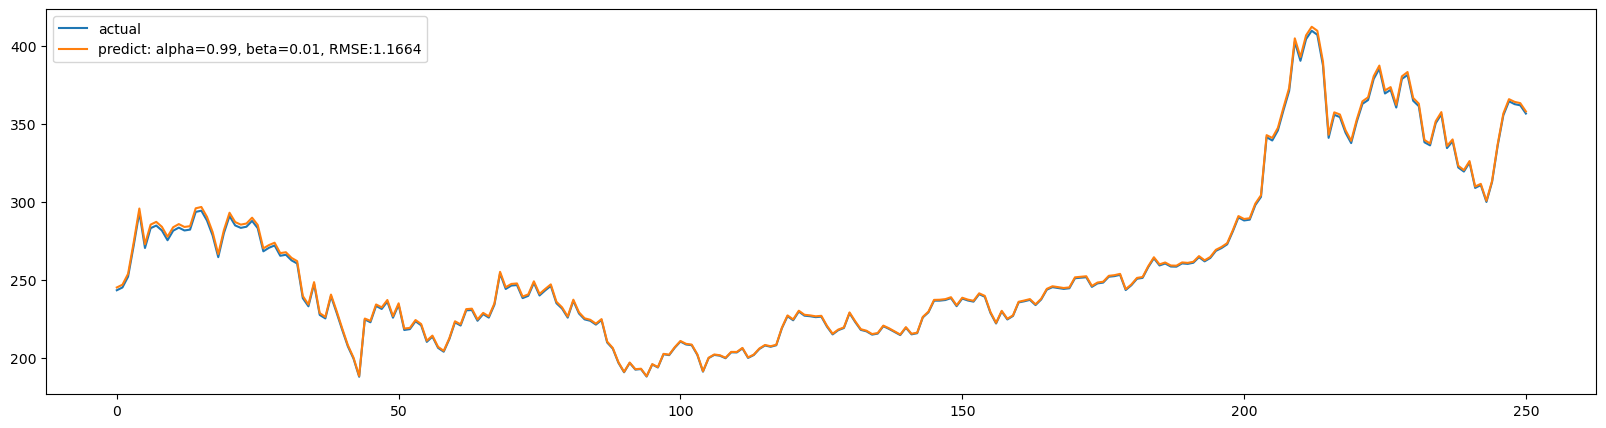

In [74]:
# previous = np.array([0,17.55,21.86,23.89,26.93,26.89])
# target = np.array([17.55,21.86,23.89,26.93,26.89,28.83])
previous = list(tesla['Close'][0:len(tesla['Close'])-1])
previous.insert(0,0)
target = list(tesla['Close'])

a0 = previous[1]
b0 = target[1]/target[0]
alpha = np.arange(0,1,0.01)
beta = np.arange(0,1,0.01)

smallest_rms = 1000
for i in alpha:
    for j in beta:
        y_predicted = holt_multi(previous,target,a0,b0,i,j)
        rms = sqrt(mean_squared_error(target, y_predicted)) 
        if (rms < smallest_rms):
            smallest_rms = rms
            opt_alpha = i
            opt_beta = j

y_real = np.array(tesla['Close'])[:251]
y_pred = holt_multi(previous,target,a0,b0,opt_alpha,opt_beta)[:251]
rms = sqrt(mean_squared_error(y_real, y_pred)) 

plt.figure(figsize=(20,5))
plt.plot(y_real)
plt.plot(y_pred)
plt.legend(["actual",f"predict: alpha={opt_alpha}, beta={opt_beta}, RMSE:{rms:.4f}"])